In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

import numpy as np
import pandas as pd
import math

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.metrics import root_mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from scipy.stats import ttest_rel
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
import pickle

from tqdm import tqdm

random_seed = 42

# VE1 cross validation

In [123]:
df = pd.read_csv('../data/descriptors_crc.csv', sep=';')

## Linear regression

In [124]:
# Features and target
X = df[['VE1_A']]
y = df['boiling_point']

# Create reusable CV splits (with fixed random_state for reproducibility)
kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

# Optionally save the splits to disk for reuse
splits = list(kf.split(X, y))
with open('cv_splits.pkl', 'wb') as f:
    pickle.dump(splits, f)

# Load splits (optional, to show how you'd reuse them)
# with open('cv_splits.pkl', 'rb') as f:
#     splits = pickle.load(f)

# Evaluate model using precomputed splits
model = LinearRegression()
mae_scores_VE1_lr = -cross_val_score(model, X, y, cv=splits, scoring='neg_mean_absolute_error')
rmse_scores_VE1_lr = -cross_val_score(model, X, y, cv=splits, scoring='neg_root_mean_squared_error')
r2_scores_VE1_lr = cross_val_score(model, X, y, cv=splits, scoring='r2')

VE1_lr_cross_metrics = {
    'rmse': rmse_scores_VE1_lr.mean(), 'rmse_std': rmse_scores_VE1_lr.std(),
    'mae': mae_scores_VE1_lr.mean(), 'mae_std': mae_scores_VE1_lr.std(),
    'r2': r2_scores_VE1_lr.mean(), 'r2_std': r2_scores_VE1_lr.std()
}
print(VE1_lr_cross_metrics)


{'rmse': 22.23290932766914, 'rmse_std': 12.57360934780437, 'mae': 16.158125226050693, 'mae_std': 5.386046246505463, 'r2': 0.9426610374343731, 'r2_std': 0.047218488904274485}


## Linear regression on log

In [125]:
df['log_VE1'] = df['VE1_A'].apply(math.log)

In [47]:
X = df[['log_VE1']]
y = df['boiling_point']


model = LinearRegression()
mae_scores = -cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
rmse_scores = -cross_val_score(model, X, y, cv=10, scoring='neg_root_mean_squared_error')
r2_scores = cross_val_score(model, X, y, cv=10, scoring='r2')

VE1_log_lr_cross_metrics = {'rmse': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
                        'mae': mae_scores.mean(), 'mae_std': mae_scores.std(),
                        'r2': r2_scores.mean(), 'r2_std': r2_scores.std()}
print(VE1_log_lr_cross_metrics)

{'rmse': 15.143411807020888, 'rmse_std': 8.569832234958929, 'mae': 11.592402434674392, 'mae_std': 5.7042827243622805, 'r2': 0.8592712379863305, 'r2_std': 0.21132359226274597}


In [109]:
# Features and target
X = df[['log_VE1']]
y = df['boiling_point']

# Create reusable CV splits (with fixed random_state for reproducibility)
# kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Optionally save the splits to disk for reuse
# splits = list(kf.split(X, y))
# with open('cv_splits.pkl', 'wb') as f:
#     pickle.dump(splits, f)

# Load splits (optional, to show how you'd reuse them)
# with open('cv_splits.pkl', 'rb') as f:
#     splits = pickle.load(f)

# Evaluate model using precomputed splits
model = LinearRegression()
mae_scores_VE1_log_lr = -cross_val_score(model, X, y, cv=splits, scoring='neg_mean_absolute_error')
rmse_scores_VE1_log_lr = -cross_val_score(model, X, y, cv=splits, scoring='neg_root_mean_squared_error')
r2_scores_VE1_log_lr = cross_val_score(model, X, y, cv=splits, scoring='r2')

VE1_log_lr_cross_metrics = {
    'rmse': rmse_scores_VE1_log_lr.mean(), 'rmse_std': rmse_scores_VE1_log_lr.std(),
    'mae': mae_scores_VE1_log_lr.mean(), 'mae_std': mae_scores_VE1_log_lr.std(),
    'r2': r2_scores_VE1_log_lr.mean(), 'r2_std': r2_scores_VE1_log_lr.std()
}
print(VE1_log_lr_cross_metrics)


{'rmse': 15.937304692973285, 'rmse_std': 5.285218645612732, 'mae': 11.331326770603187, 'mae_std': 2.713590875204556, 'r2': 0.9487960286500996, 'r2_std': 0.06700797974771139}


## Polynomial fit

In [49]:
df.head(3)

,boiling_point,SMILES,IUPAC_name,InChIKey,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,log_VE1
0,-0.5,CCCC,butane,IJDNQMDRQITEOD-UHFFFAOYSA-N,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,...,22.328143,58.078250,4.148446,10.0,1.0,10.0,8.0,2.50,1.25,0.666032
1,216.3,CCCCCCCCCCCC,dodecane,SNRUBQQJIBEYMU-UHFFFAOYSA-N,14.592460,1.941884,3.883767,14.592460,1.216038,3.291100,...,38.766486,170.203451,4.479038,286.0,9.0,42.0,40.0,4.50,3.25,1.172582
2,-42.1,CCC,propane,ATUOYWHBWRKTHZ-UHFFFAOYSA-N,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,17.310771,44.062600,4.005691,4.0,0.0,6.0,4.0,2.25,1.00,0.534800


In [41]:
degree = 2
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(df[['VE1_A']])
model_poly = LinearRegression().fit(X_poly, y)
mae_scores_pf = -cross_val_score(model_poly, X_poly, y, cv=10, scoring='neg_mean_absolute_error')
rmse_scores_pf = -cross_val_score(model_poly, X_poly, y, cv=10, scoring='neg_root_mean_squared_error')
r2_scores_pf = cross_val_score(model_poly, X_poly, y, cv=10, scoring='r2')

VE1_pf_cross_metrics = {'rmse': rmse_scores_pf.mean(), 'rmse_std': rmse_scores_pf.std(),
                        'mae': mae_scores_pf.mean(), 'mae_std': mae_scores_pf.std(),
                        'r2': r2_scores_pf.mean(), 'r2_std': r2_scores_pf.std()}
print(VE1_pf_cross_metrics)

{'rmse': 11.719321052250464, 'rmse_std': 3.364146236251987, 'mae': 9.139844223569169, 'mae_std': 2.245409703935074, 'r2': 0.8730083814346514, 'r2_std': 0.19730367839775664}


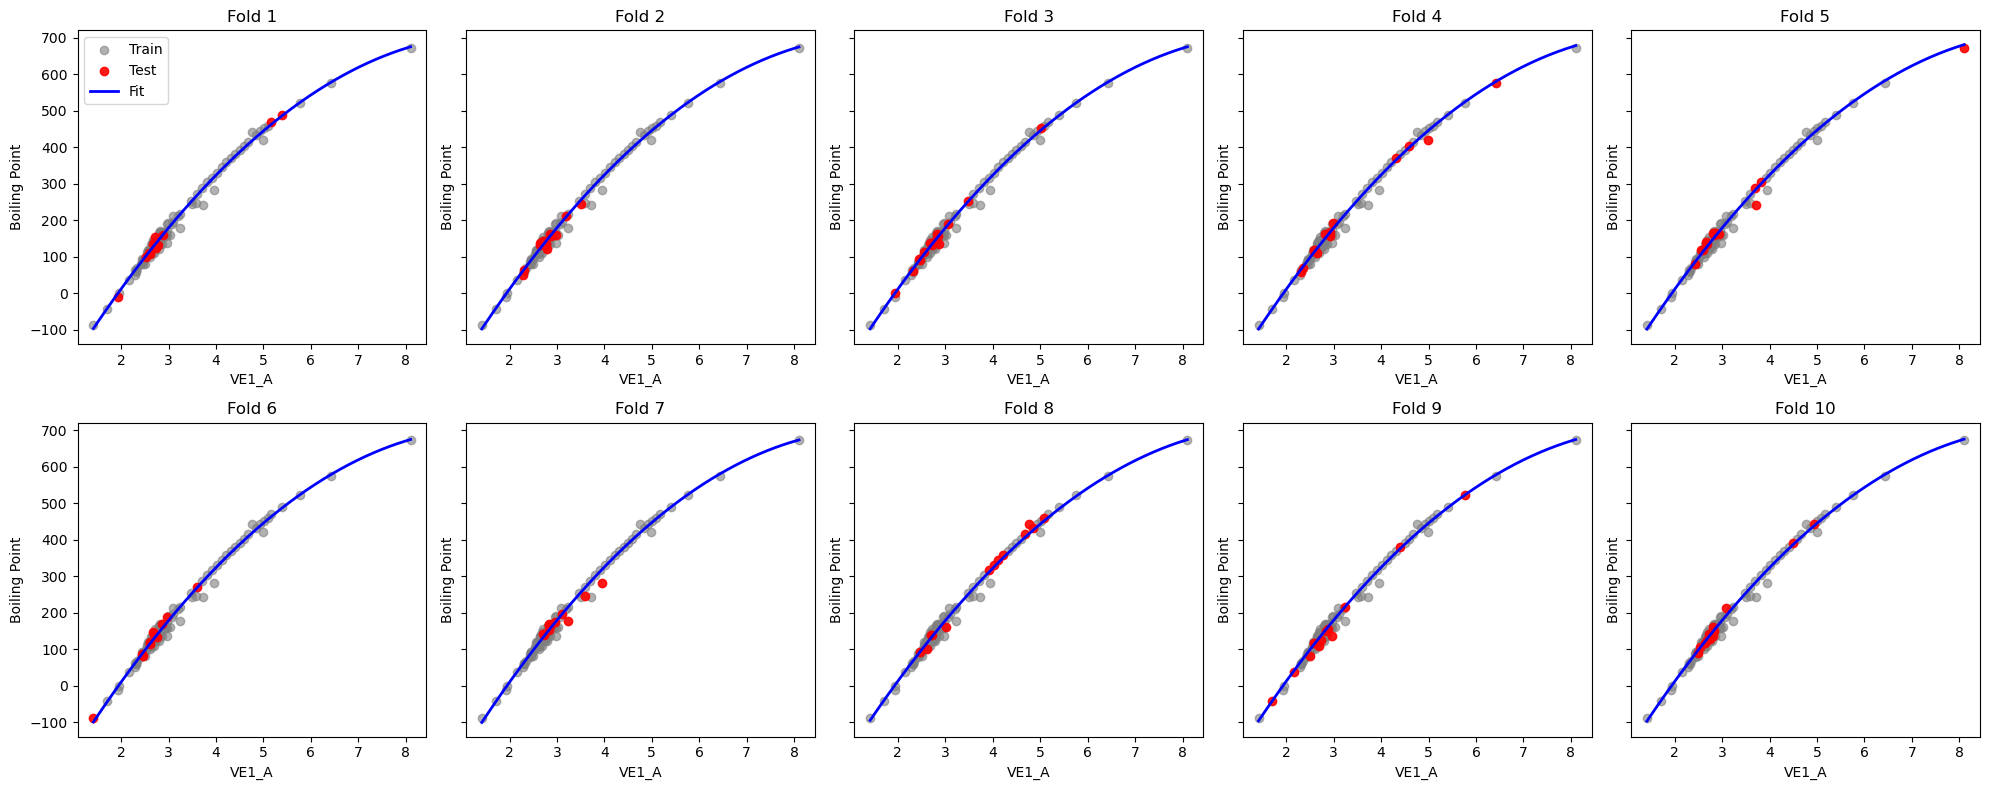

{'rmse': 11.63392607320056, 'rmse_std': 2.9716963702443797, 'mae': 8.992981498217556, 'mae_std': 2.1378496632816586, 'r2': 0.9679447317615584, 'r2_std': 0.05684925208513669}


In [110]:
# Data
X = df[['VE1_A']].values
y = df['boiling_point'].values

# Polynomial degree
degree = 2
pipeline = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Store metrics for each fold
mae_scores_VE1_pf = []
rmse_scores_VE1_pf = []
r2_scores_VE1_pf = []

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.ravel()

for i, (train_idx, test_idx) in enumerate(splits):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Fit model on training data
    pipeline.fit(X_train, y_train)

    # Predict test set
    y_pred = pipeline.predict(X_test)

    # Save metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mae_scores_VE1_pf.append(mae)
    rmse_scores_VE1_pf.append(rmse)
    r2_scores_VE1_pf.append(r2)

    # Predict for plotting curve
    x_curve = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
    y_curve = pipeline.predict(x_curve)

    # Plot
    ax = axes[i]
    ax.scatter(X_train, y_train, color='gray', alpha=0.6, label='Train')
    ax.scatter(X_test, y_test, color='red', alpha=0.9, label='Test')
    ax.plot(x_curve, y_curve, color='blue', lw=2, label='Fit')
    ax.set_title(f'Fold {i+1}')
    ax.set_xlabel('VE1_A')
    ax.set_ylabel('Boiling Point')

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

# Final metrics dictionary
VE1_pf_cross_metrics = { 
    'rmse': np.mean(rmse_scores_VE1_pf), 'rmse_std': np.std(rmse_scores_VE1_pf),
    'mae': np.mean(mae_scores_VE1_pf), 'mae_std': np.std(mae_scores_VE1_pf),
    'r2': np.mean(r2_scores_VE1_pf), 'r2_std': np.std(r2_scores_VE1_pf)
}

print(VE1_pf_cross_metrics)


Coefficients: [  0.         225.70946539 -11.57699074]
Intercept: -393.97050441246245


c:\Users\barca\miniconda3\envs\BP\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


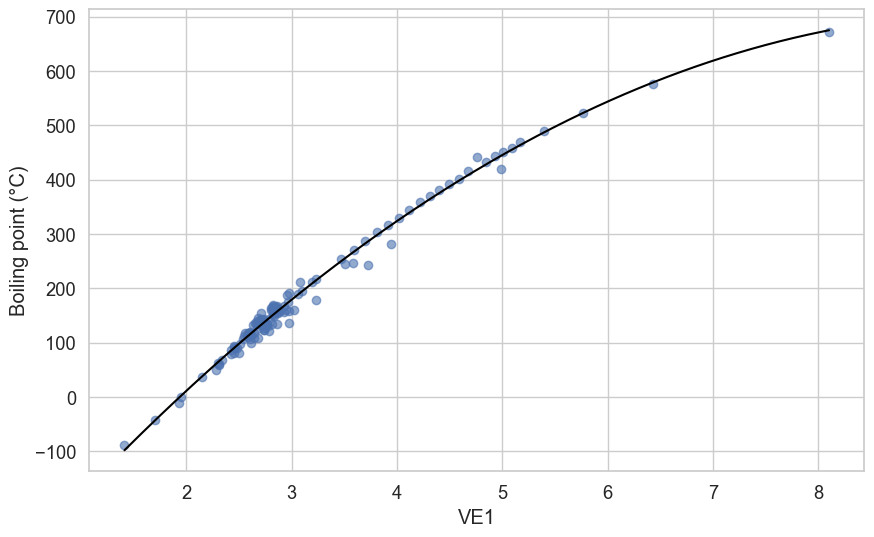

In [160]:
# Refit on whole dataset to get coefficients
X_poly = poly.fit_transform(df[['VE1_A']])
model_poly = LinearRegression().fit(X_poly, y)
coefficients = model_poly.coef_
intercept = model_poly.intercept_
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')
# Plotting the polynomial fit
plt.figure(figsize=(10, 6)) 
plt.scatter(df['VE1_A'], df['boiling_point'], color='#4C72B0', alpha=0.6, label='Data')
x_curve = np.linspace(df['VE1_A'].min(), df['VE1_A'].max(), 500).reshape(-1, 1)
x_curve_poly = poly.transform(x_curve)
y_curve = model_poly.predict(x_curve_poly)
plt.plot(x_curve, y_curve, color='black', label='Polynomial Fit')
plt.xlabel('VE1')
plt.ylabel('Boiling point (°C)')
# plt.title('Polynomial Regression Fit')
# plt.legend()
plt.savefig("../img/ve1_pf.svg", format="svg")
plt.show()

## Polynomial fit on log

In [12]:
degree = 2
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(df[['log_VE1']])
model_poly = LinearRegression().fit(X_poly, y)
mae_scores = -cross_val_score(model_poly, X_poly, y, cv=10, scoring='neg_mean_absolute_error')
rmse_scores = -cross_val_score(model_poly, X_poly, y, cv=10, scoring='neg_root_mean_squared_error')
r2_scores = cross_val_score(model_poly, X_poly, y, cv=10, scoring='r2')

VE1_log_pf_cross_metrics = {'rmse': rmse_scores.mean(), 'rmse_std': rmse_scores.std(),
                        'mae': mae_scores.mean(), 'mae_std': mae_scores.std(),
                        'r2': r2_scores.mean(), 'r2_std': r2_scores.std()}
print(VE1_log_pf_cross_metrics)

{'rmse': 14.723591497419047, 'rmse_std': 7.010242705909148, 'mae': 10.983922934686069, 'mae_std': 4.2449626010253905, 'r2': 0.872206499446006, 'r2_std': 0.18621902444812685}


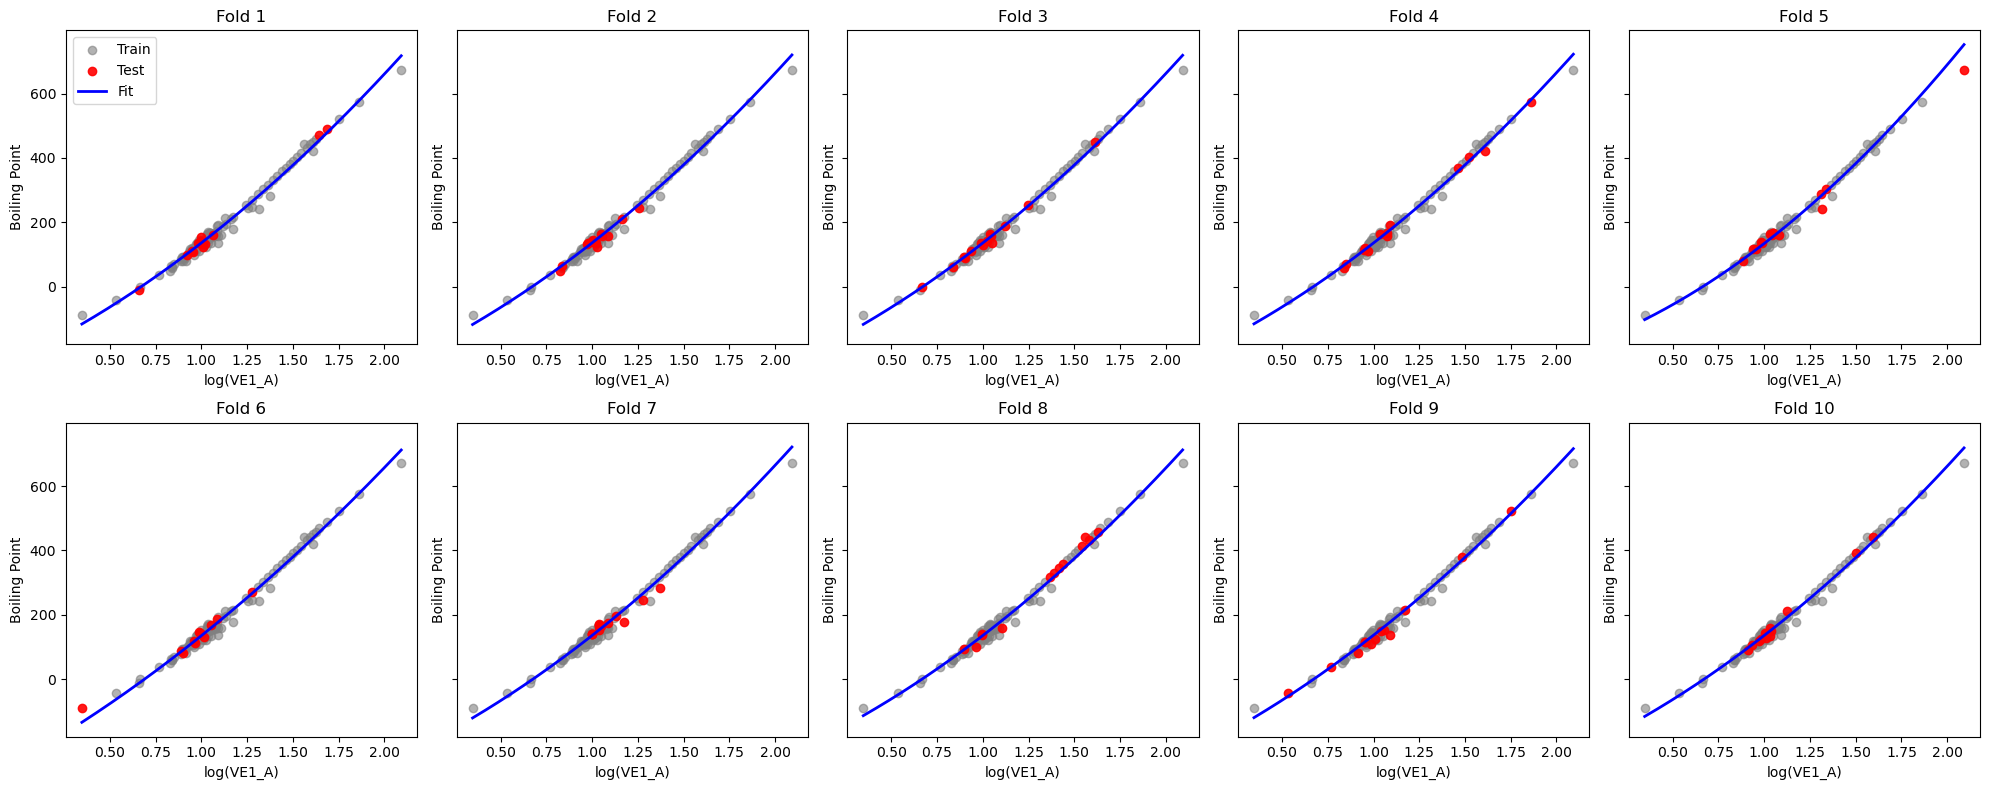

{'rmse': 13.996826256587013, 'rmse_std': 4.906469450744137, 'mae': 10.55945244803371, 'mae_std': 2.930414307272351, 'r2': 0.9648685992413656, 'r2_std': 0.04738525651405707}


In [111]:
# Data
X = df[['log_VE1']].values
y = df['boiling_point'].values

# Polynomial degree
degree = 2
pipeline = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Store metrics for each fold
mae_scores_VE1_log_pf = []
rmse_scores_VE1_log_pf = []
r2_scores_VE1_log_pf = []

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.ravel()

for i, (train_idx, test_idx) in enumerate(splits):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Fit model on training data
    pipeline.fit(X_train, y_train)

    # Predict test set
    y_pred = pipeline.predict(X_test)

    # Save metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mae_scores_VE1_log_pf.append(mae)
    rmse_scores_VE1_log_pf.append(rmse)
    r2_scores_VE1_log_pf.append(r2)

    # Predict for plotting curve
    x_curve = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
    y_curve = pipeline.predict(x_curve)

    # Plot
    ax = axes[i]
    ax.scatter(X_train, y_train, color='gray', alpha=0.6, label='Train')
    ax.scatter(X_test, y_test, color='red', alpha=0.9, label='Test')
    ax.plot(x_curve, y_curve, color='blue', lw=2, label='Fit')
    ax.set_title(f'Fold {i+1}')
    ax.set_xlabel('log(VE1_A)')
    ax.set_ylabel('Boiling Point')

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

# Final metrics dictionary
VE1_log_pf_cross_metrics = { 
    'rmse': np.mean(rmse_scores_VE1_log_pf), 'rmse_std': np.std(rmse_scores_VE1_log_pf),
    'mae': np.mean(mae_scores_VE1_log_pf), 'mae_std': np.std(mae_scores_VE1_log_pf),
    'r2': np.mean(r2_scores_VE1_log_pf), 'r2_std': np.std(r2_scores_VE1_log_pf)
}

print(VE1_log_pf_cross_metrics)


In [126]:
df['log_W'] = df['WPath'].apply(math.log)

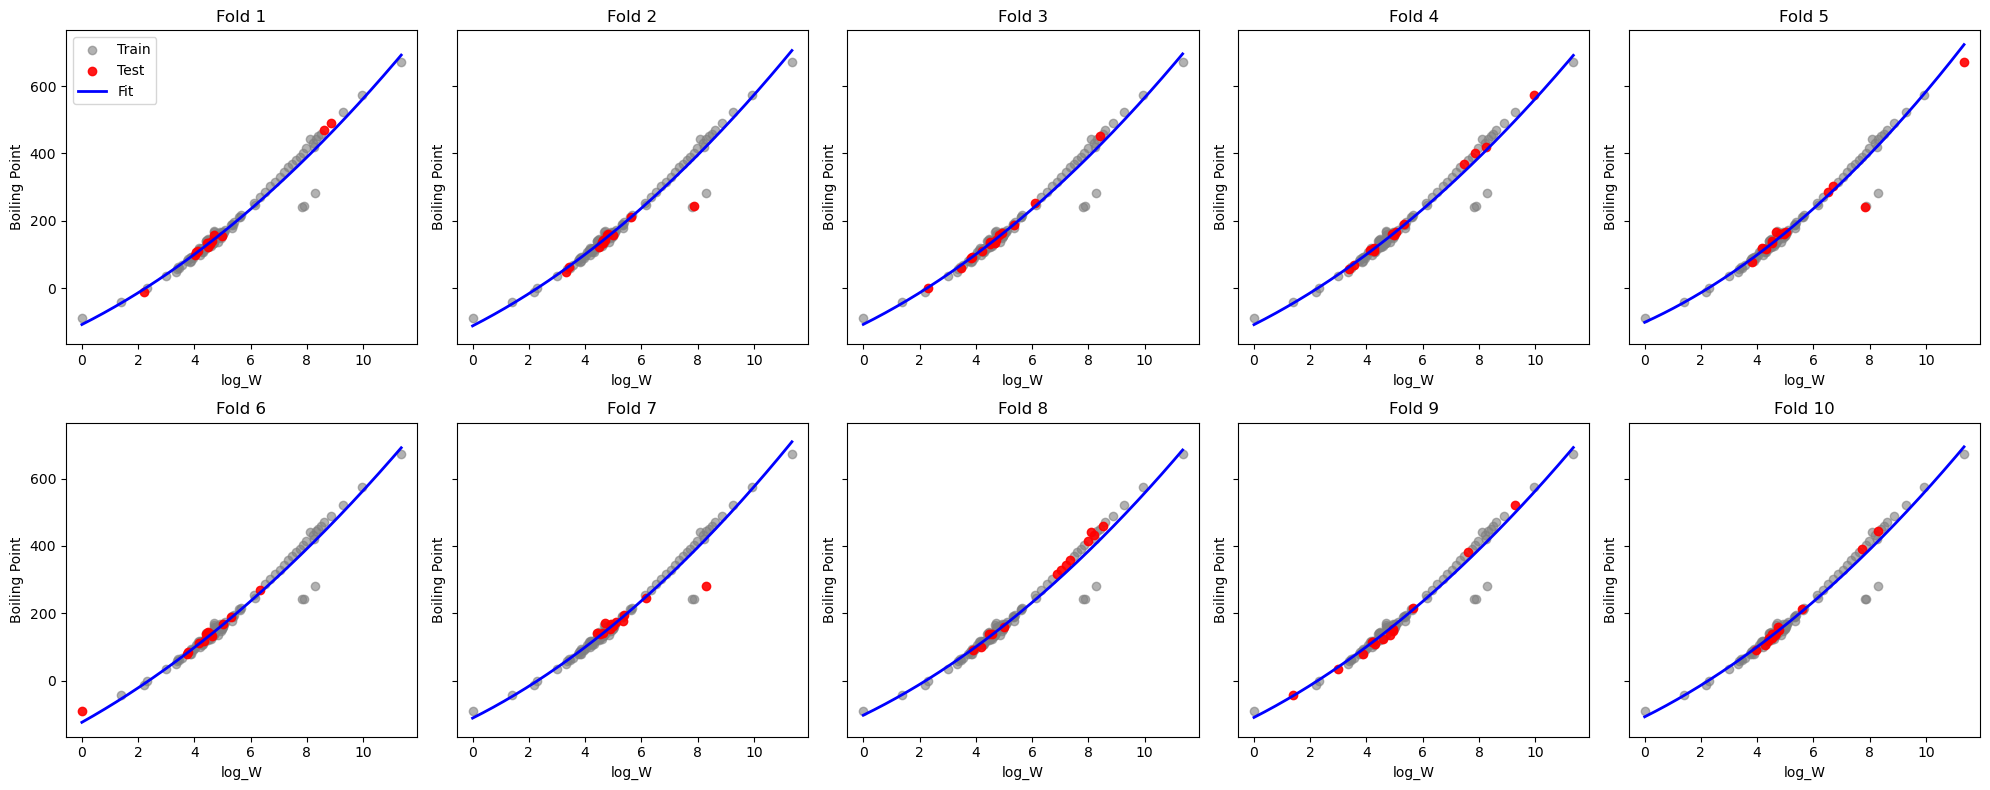

{'rmse': 21.241121349351207, 'rmse_std': 12.525090491866536, 'mae': 12.20058683965279, 'mae_std': 5.030399988269395, 'r2': 0.8216707263573421, 'r2_std': 0.31836432500331885}


In [114]:
# Data
X = df[['log_W']].values
y = df['boiling_point'].values

# Polynomial degree
degree = 2
pipeline = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Store metrics for each fold
mae_scores_log_W = []
rmse_scores_log_W = []
r2_scores_log_W = []

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.ravel()

for i, (train_idx, test_idx) in enumerate(splits):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Fit model on training data
    pipeline.fit(X_train, y_train)

    # Predict test set
    y_pred = pipeline.predict(X_test)

    # Save metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mae_scores_log_W.append(mae)
    rmse_scores_log_W.append(rmse)
    r2_scores_log_W.append(r2)

    # Predict for plotting curve
    x_curve = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
    y_curve = pipeline.predict(x_curve)

    # Plot
    ax = axes[i]
    ax.scatter(X_train, y_train, color='gray', alpha=0.6, label='Train')
    ax.scatter(X_test, y_test, color='red', alpha=0.9, label='Test')
    ax.plot(x_curve, y_curve, color='blue', lw=2, label='Fit')
    ax.set_title(f'Fold {i+1}')
    ax.set_xlabel('log_W')
    ax.set_ylabel('Boiling Point')

    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

# Final metrics dictionary
log_W_pf_cross_metrics = { 
    'rmse': np.mean(rmse_scores_log_W), 'rmse_std': np.std(rmse_scores_log_W),
    'mae': np.mean(mae_scores_log_W), 'mae_std': np.std(mae_scores_log_W),
    'r2': np.mean(r2_scores_log_W), 'r2_std': np.std(r2_scores_log_W)
}

print(log_W_pf_cross_metrics)


In [62]:
print(df[['boiling_point', 'WPath', 'SMILES']].sort_values(by='WPath', ascending=False).head(10))

     boiling_point    WPath                                             SMILES
89           672.0  85320.0  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
93           575.0  20825.0  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
103          522.0  10660.0           CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
100          489.0   7140.0                CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
40           470.0   5456.0                   CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
58           458.0   4960.0                    CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
113          451.0   4495.0                     CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
87           443.0   4060.0                      CCCCCCCCCCCCCCCCCCCCCCCCCCCCC
6            282.0   3960.0                  CCCCCCCCCCC(CCCCCCCCCC)CCCCCCCCCC
65           420.0   3803.0         CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCCC(C)C


# Comparison

In [65]:
data = {
    "VE1_lr": VE1_lr_cross_metrics,
    "VE1_log_lr": VE1_log_lr_cross_metrics,
    "VE1_pf": VE1_pf_cross_metrics,
    "VE1_log_pf": VE1_log_pf_cross_metrics,
    "log_W_pf": log_W_pf_cross_metrics
}

df_comp = pd.DataFrame.from_dict(data, orient='index')

def highlight_best(s):
    max_r2 = df_comp['r2'].max()
    min_rmse = df_comp['rmse'].min()
    min_mae = df_comp['mae'].min()
    
    return [
        'background-color: green' if (
            (s.name == 'r2' and v == max_r2) or 
            (s.name == 'rmse' and v == min_rmse) or 
            (s.name == 'mae' and v == min_mae)
        ) else '' 
        for v in s
    ]

styled_df = df_comp.style.apply(highlight_best, axis=0)
styled_df

,rmse,rmse_std,mae,mae_std,r2,r2_std
VE1_lr,22.232909,12.573609,16.158125,5.386046,0.942661,0.047218
VE1_log_lr,15.937305,5.285219,11.331327,2.713591,0.948796,0.067008
VE1_pf,11.633926,2.971696,8.992981,2.137850,0.967945,0.056849
VE1_log_pf,13.996826,4.906469,10.559452,2.930414,0.964869,0.047385
log_W_pf,21.241121,12.525090,12.200587,5.030400,0.821671,0.318364


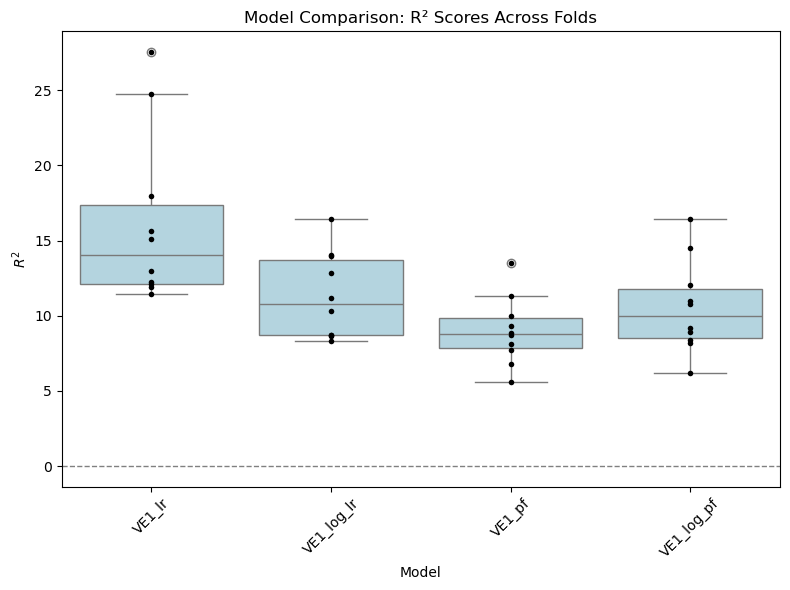

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine into a long-format DataFrame
data = {
    'VE1_lr': mae_scores_VE1_lr,
    'VE1_log_lr': mae_scores_VE1_log_lr,
    'VE1_pf': mae_scores_VE1_pf,
    'VE1_log_pf': mae_scores_VE1_log_pf,
    # 'log_W': mae_scores_log_W
}
df_viz = pd.DataFrame(data)
df_long = df_viz.melt(var_name='Model', value_name='R²')

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_long, x='Model', y='R²', color='lightblue')
sns.stripplot(data=df_long, x='Model', y='R²', color='black', size=4, jitter=False)
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.ylabel('$R^2$')
plt.xticks(rotation=45)
plt.title('Model Comparison: R² Scores Across Folds')
plt.tight_layout()
plt.show()


## Comparison with Wieners equation

In [4]:
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

In [128]:
def calculate_polarity_number(mol):
    dm = Chem.GetDistanceMatrix(mol)
    p = 0
    n = dm.shape[0]
    for i in range(n):
        for j in range(n):
            if(dm[i][j] == 3): p += 1
        
    return int(p/2)

In [129]:
df['polarity_number'] = df.Mol.apply(calculate_polarity_number)

In [130]:
df['num_atoms'] = df['Mol'].apply(lambda mol: sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() == 'C'))

In [131]:
df_chains = df[~df['SMILES'].str.contains(r'\(')].copy()

In [132]:
df['n_isomer_p'] = df['num_atoms'].map(df_chains.set_index('num_atoms')['polarity_number'])
df['n_isomer_bp'] = df['num_atoms'].map(df_chains.set_index('num_atoms')['boiling_point'])
df['n_isomer_w'] = df['num_atoms'].map(df_chains.set_index('num_atoms')['WPath'])

In [133]:
df['delta_p'] = df['n_isomer_p'] - df['polarity_number']
df['delta_bp'] = df['n_isomer_bp'] - df['boiling_point']
df['delta_w'] = df['n_isomer_w'] - df['WPath']

In [9]:
df[['SMILES','delta_bp','delta_w','delta_p','num_atoms']].sample(3)

,SMILES,delta_bp,delta_w,delta_p,num_atoms
122,CC(C)CCC(C)(C)C,26.8,22,0,9
72,CCCCC(C)CC,6.7,8,-1,8
21,CCCC(C)C(C)C,10.0,14,-2,8


In [135]:
df['delta_t'] = (98 / (df['num_atoms']**2)) * df['delta_w'] + 5.5 * df['delta_p']

In [136]:
df['deviation'] = df['boiling_point'] - (df['n_isomer_bp'] - df['delta_t'])
df['predicted_bp'] = df['n_isomer_bp'] - df['delta_t']

In [137]:
df[['SMILES','delta_bp','delta_w','delta_p','num_atoms', 'delta_t', 'boiling_point', 'n_isomer_bp', 'deviation', 'predicted_bp']].sample(3)


,SMILES,delta_bp,delta_w,delta_p,num_atoms,delta_t,boiling_point,n_isomer_bp,deviation,predicted_bp
70,CCCCCCC(C)CCC,7.9,18.0,-1,11,9.078512,188.0,195.9,1.178512,186.821488
44,CCC(C(C)C)C(C)C,27.8,30.0,-4,9,14.296296,123.0,150.8,-13.503704,136.503704
108,CCC(C)(C)C(C)(C)CC,4.1,54.0,-8,10,8.920000,170.0,174.1,4.820000,165.180000


In [162]:
# List to store R² scores for each fold
r2_scores_WEQ = []
rmse_scores_WEQ = []
mae_scores_WEQ = []

# Loop over each split (test indices)
for train_idx, test_idx in splits:
    y_true = df.loc[test_idx, 'boiling_point']
    y_pred = df.loc[test_idx, 'predicted_bp']
    r2 = r2_score(y_true, y_pred)
    r2_scores_WEQ.append(r2)
    rmse = root_mean_squared_error(y_true, y_pred)
    rmse_scores_WEQ.append(rmse)
    mae = mean_absolute_error(y_true, y_pred)
    mae_scores_WEQ.append(mae)

print(np.mean(r2_scores_WEQ))
print(np.mean(rmse_scores_WEQ))
print(np.mean(mae_scores_WEQ))


0.8917855013330913
11.087263755940661
3.9431865106865347


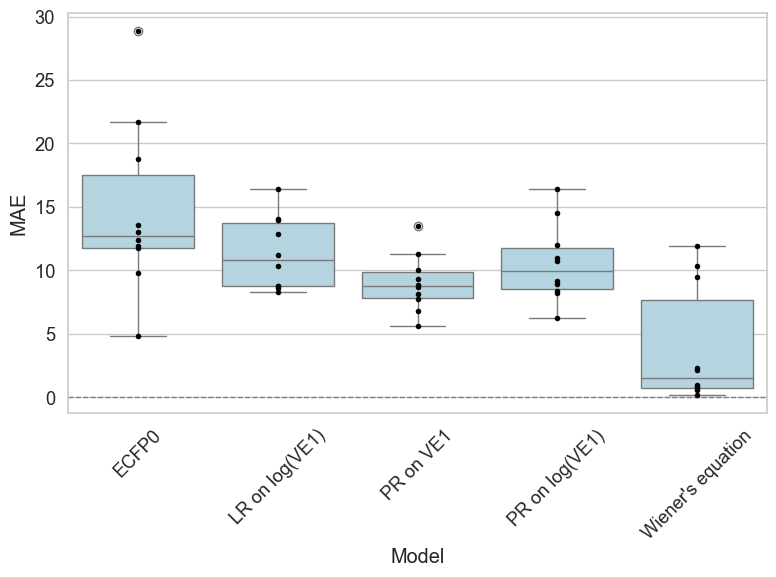

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine into a long-format DataFrame
data = {
    'ECFP0': mae_scores_ecfp,
    'LR on log(VE1)': mae_scores_VE1_log_lr,
    'PR on VE1': mae_scores_VE1_pf,
    'PR on log(VE1)': mae_scores_VE1_log_pf,
    "Wiener's equation": mae_scores_WEQ
}
df_viz = pd.DataFrame(data)
df_long = df_viz.melt(var_name='Model', value_name='R²')

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_long, x='Model', y='R²', color='lightblue')
sns.stripplot(data=df_long, x='Model', y='R²', color='black', size=4, jitter=False)
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.ylabel('MAE')
plt.xticks(rotation=45)
# plt.title('Model Comparison: R² Scores Across Folds')
plt.tight_layout()
plt.savefig("../img/alkane_box_plot.svg", format="svg")
plt.show()

In [89]:
def get_metrics(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

In [90]:
metrics_crc = get_metrics(df['boiling_point'], df['predicted_bp'])
metrics_crc

{'RMSE': 17.98206742394699,
 'MAE': 3.9955103959259843,
 'R2': 0.9783374942878477}

In [91]:
df_branched = df[df['SMILES'].str.contains(r'\(')].copy()

In [92]:
metrics_crc = get_metrics(df_branched['boiling_point'], df_branched['predicted_bp'])
metrics_crc

{'RMSE': 20.78958495276123,
 'MAE': 5.3405336975248305,
 'R2': 0.8251630123201352}

# Statistical comparison with ECFP0

In [12]:
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

In [13]:
from sklearn.model_selection import cross_val_score, KFold

In [153]:
MFPGEN = rdFingerprintGenerator.GetMorganGenerator(fpSize=256, radius=0)
X = np.stack(df.Mol.apply(MFPGEN.GetCountFingerprintAsNumPy).values)
y = df['boiling_point'].values


# Model
model = RandomForestRegressor(n_estimators=20, random_state=random_seed)

# Evaluate using the same folds
mae_scores_ecfp = -cross_val_score(model, X, y, cv=splits, scoring='neg_mean_absolute_error')
rmse_scores_ecfp = -cross_val_score(model, X, y, cv=splits, scoring='neg_root_mean_squared_error')
r2_scores_ecfp = cross_val_score(model, X, y, cv=splits, scoring='r2')

# Collect results
ecfp_scores = {
    'rmse': rmse_scores_ecfp.mean(),
    'rmse_std': rmse_scores_ecfp.std(),
    'mae': mae_scores_ecfp.mean(),
    'mae_std': mae_scores_ecfp.std(),
    'r2': r2_scores_ecfp.mean(),
    'r2_std': r2_scores_ecfp.std()
}

ecfp_scores

{'rmse': 24.774490007890954,
 'rmse_std': 14.05272606791326,
 'mae': 14.649162104897547,
 'mae_std': 6.437612169127502,
 'r2': 0.7821293638819947,
 'r2_std': 0.5063432210219538}

In [163]:
t_stat, p_value = ttest_rel(rmse_scores_WEQ, rmse_scores_ecfp, alternative='less')
print(f"t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")

t-statistic: -2.7585, p-value: 0.0111
